In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import json
import nltk
import wordcloud
import spacy

In [14]:
df = pd.read_json("../../ITA_WS_2020/datasets/recipe1m/recipes_with_nutritional_info.json")
def convert(column_string):
    if column_string:
        return [result["text"] for result in column_string]
    return np.nan

# convert all the strings to lists in
for column in ["ingredients", "instructions"]:
    df[column] = df[column].apply(convert)
df.head()
df = df.rename(columns={"instructions":"directions"})

In [15]:
print(f"Number of recipes before dropna: {len(df)}")
df.dropna(inplace=True, subset=["directions","ingredients"])
print(f"Number of recipes after dropna: {len(df)}")

Number of recipes before dropna: 51235
Number of recipes after dropna: 51235


## Ingredients

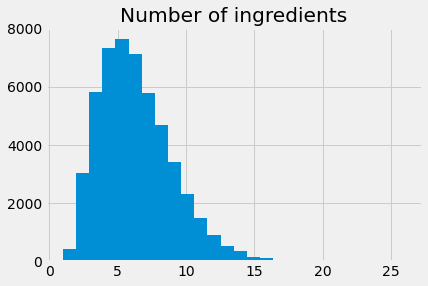

Median number of ingredients: 6.0
Std. deviation of number of ingredients: 2.81


In [16]:
def count_ingredients(ingredients):
    if isinstance(ingredients, list):
        return len(ingredients)
    else:
        return 0

df['n_ingredients'] = df.ingredients.apply(count_ingredients)

#plot distribution
plt.title("Number of ingredients")
plt.hist(df.n_ingredients.tolist(), bins=max(df.n_ingredients.tolist()))
plt.show()

print(f"Median number of ingredients: {df.n_ingredients.median()}")
print(f"Std. deviation of number of ingredients: {df.n_ingredients.std():.2f}")

The median number of ingredients is 6, which seems plausible. However, the majority has 1-15 ingredients.

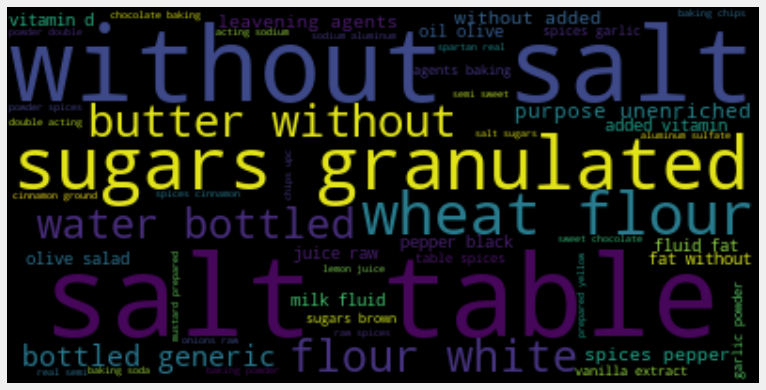

In [18]:
total_ingredients = nltk.flatten(df.ingredients.tolist())
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(total_ingredients))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

As one can see, salt is the most prominent ingredient. However, the ingredients include adjectives and some common words(without, bottled, fluid, added etc.). This needs to be cleaned to obtain the real ingredients.

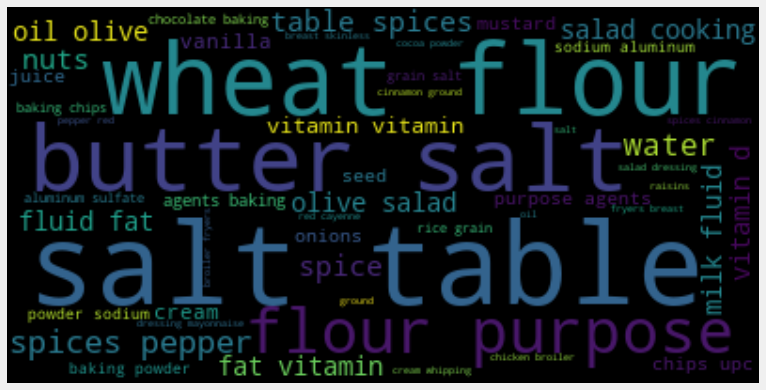

In [19]:
nlp = spacy.load("en_core_web_sm")
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if word.pos_ == "NOUN"]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")

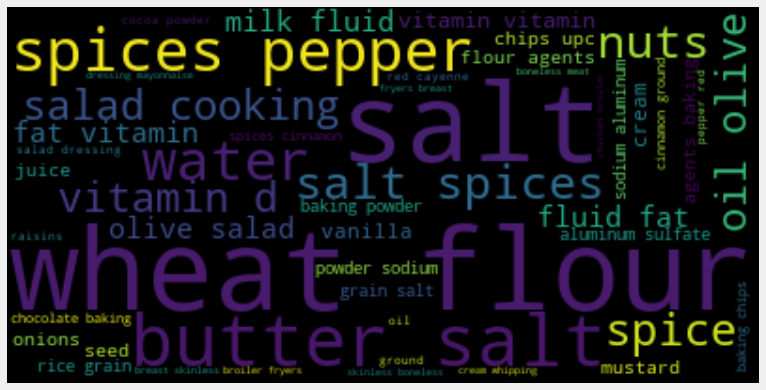

In [21]:
# without units (special stopwords)
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "pound", "pounds", "ounce", "ounces","slice","slices", "piece", "pieces", "purpose","table"}
processed_ingredients = [nlp(text) for text in total_ingredients[:1000]]
nouns = [str(word) for ingredient in processed_ingredients for word in ingredient if (word.pos_ == "NOUN" and not word.is_stop)]
wc = wordcloud.WordCloud(max_words=50, max_font_size=60).generate(" ".join(nouns))

fig = plt.figure(1, figsize=(12, 12))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")


## Directions

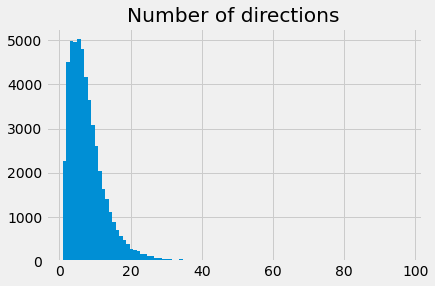

Median number of directions: 6.0
Std. deviation of number of directions: 5.79


In [22]:
def count_directions(directions):
    if isinstance(directions, list):
        return len(directions)
    else:
        return 0

df['n_directions'] = df.directions.apply(count_directions)

#plot distribution
plt.title("Number of directions")
plt.hist(df.n_directions.tolist(), bins=max(df.n_directions.tolist()))
plt.show()

print(f"Median number of directions: {df.n_directions.median()}")
print(f"Std. deviation of number of directions: {df.n_directions.std():.2f}")

Interestingly, ther are quite a lot of recipes with only a few directions (i.e. simple recipes). Only a samll number of recipes have more than 20 directions.

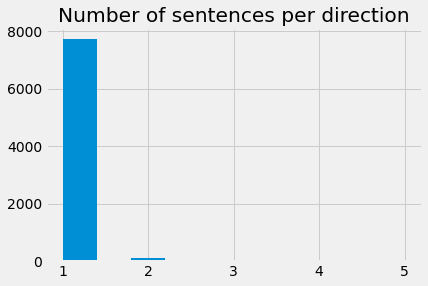

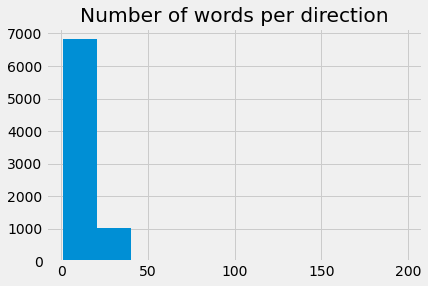

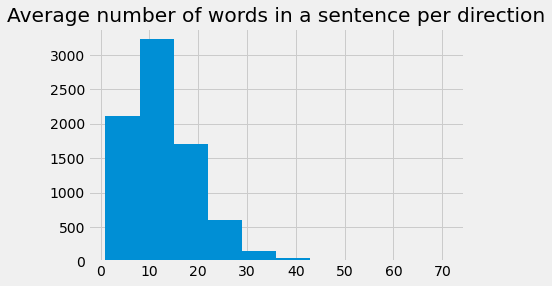

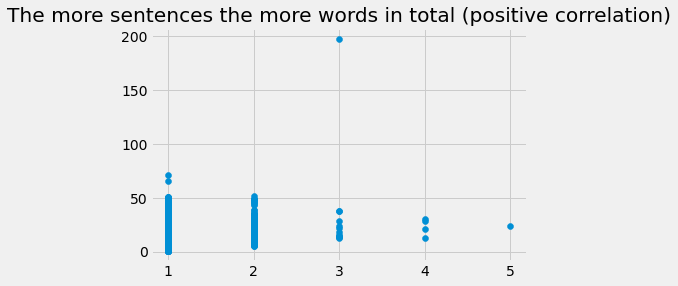

In [24]:
#number of words, sentences in directions 
processed_directions = [nlp(direction) for direction in nltk.flatten(df.directions.tolist()[:1000]) if isinstance(direction, str)]
sentences_per_direction = [len(list(processed_direction.sents)) for processed_direction in processed_directions]
plt.title("Number of sentences per direction")
plt.hist(sentences_per_direction)
plt.show()

words_per_direction = [len(processed_direction) for processed_direction in processed_directions]
plt.title("Number of words per direction")
plt.hist(words_per_direction)
plt.show()

plt.title("Average number of words in a sentence per direction")
plt.hist(np.array(words_per_direction) / np.array(sentences_per_direction))
plt.show()

plt.title("The more sentences the more words in total (positive correlation)")
plt.scatter(sentences_per_direction, words_per_direction)
plt.show()

The instructions seem to be mostly one sentenced, this might have to do with the preprocessing done by the authors.

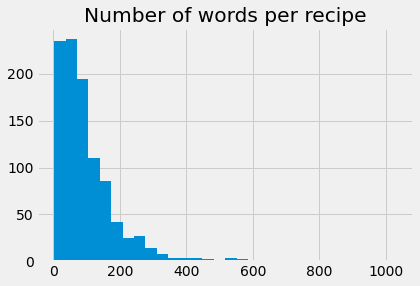

In [26]:
def count_words(directions):
    return len(nlp(" ".join(directions)))

df['word_count'] = df.directions[:1000].apply(count_words)
plt.title("Number of words per recipe")
plt.hist(df.word_count.tolist(), bins=30)
plt.show()

Some the recipes are short. This might be caused by sorting in the dataset.
#FIXME: RUN over night